In [1]:
using MicroMag
using NPZ

@using_gpu()

The system is a rectangular film of magnetic material with dimensions 100 nm × 100 nm × 10 nm.

In [2]:
mesh = FDMesh(nx=20,ny=20,nz=2,dx=5e-9,dy=5e-9,dz=5e-9);

Initialize a vortex roughly.

In [3]:
function init_fun(i,j,k,dx,dy,dz)
    x = i-10
    y = j-10
    r = (x^2+y^2)^0.5
    if r<2
      return (0,0,1)
    end
    return (y/r, -x/r, 0)
end

init_fun (generic function with 1 method)

The material parameters of permalloy
const A = 1.3e-11
const Ms = 8e5

## Step 1: Relax the system.
Relax the system into a energy-optimal state by steepest descent driver.

In [4]:
function relax_vortex(mesh)
    sim = Sim(mesh,driver="SD",name="std5")

    A = 1.3e-11
    Ms = 8e5
    set_Ms(sim, Ms)
    add_exch(sim, A) #exchange length=5.7nm
    add_demag(sim)

    init_m0(sim,init_fun)
    relax(sim, maxsteps=10000, save_m_every=-1)

    npzwrite("std5_m0.npy", Array(sim.spin))
end

relax_vortex (generic function with 1 method)

## Step 2: Vortex dynamics.
Run the current driven dynamics.

In [5]:
function applied_current(mesh, ux, beta)
    m0 = npzread("std5_m0.npy")
    sim = Sim(mesh,driver="LLG_STT", name="std5_dyn")
    sim.driver.alpha=0.1
    sim.driver.gamma = 2.211e5
    sim.driver.beta = beta

    A = 1.3e-11
    Ms = 8e5
    set_Ms(sim,Ms)

    add_exch(sim,A) #exchange length=5.7 nm
    add_demag(sim)

    init_m0(sim, m0)
    set_ux(sim,ux)

    fname = "std5_center.txt"
    io = open(fname,"w")

    #Use formatstring function to convert the contents into fixed-length string.
    write(io, MicroMag.formatstring("time(s)"))
    write(io, MicroMag.formatstring("X(m)"))
    write(io, MicroMag.formatstring("Y(m)"))
    write(io, "\n")

    for i=0:800
        t = i * 1e-11
        run_until(sim, t)
        #compute the x,y coordinate of vortex center for layer 1.
        Rx, Ry = MicroMag.compute_guiding_center(sim, z=1)

        write(io, MicroMag.formatstring(t))
        write(io, MicroMag.formatstring(Rx))
        write(io, MicroMag.formatstring(Ry))
        write(io, "\n")

        if i%20 ==0
            println("time=", t)
        end
    end
    close(io)
end

applied_current (generic function with 1 method)

Choose using either CPU or GPU and run the first step.

In [6]:
isfile("std5_m0.npy") || relax_vortex(mesh)

true

Choose a proper current density and run the second step.
$ux=-Pg\mu_BJ/(2eM_s)$
where J=1e12 is the current density， P=1 is the polarization rate,
$g# is the Lander factor of free electrons, $e$ is the charge of an electron.

In [7]:
if !(isfile("std5_dyn_llg_stt.txt") && isfile("std5_center.txt"))
    ux = -72.438
    applied_current(mesh, ux, 0.05)
end

Plot the initial state.

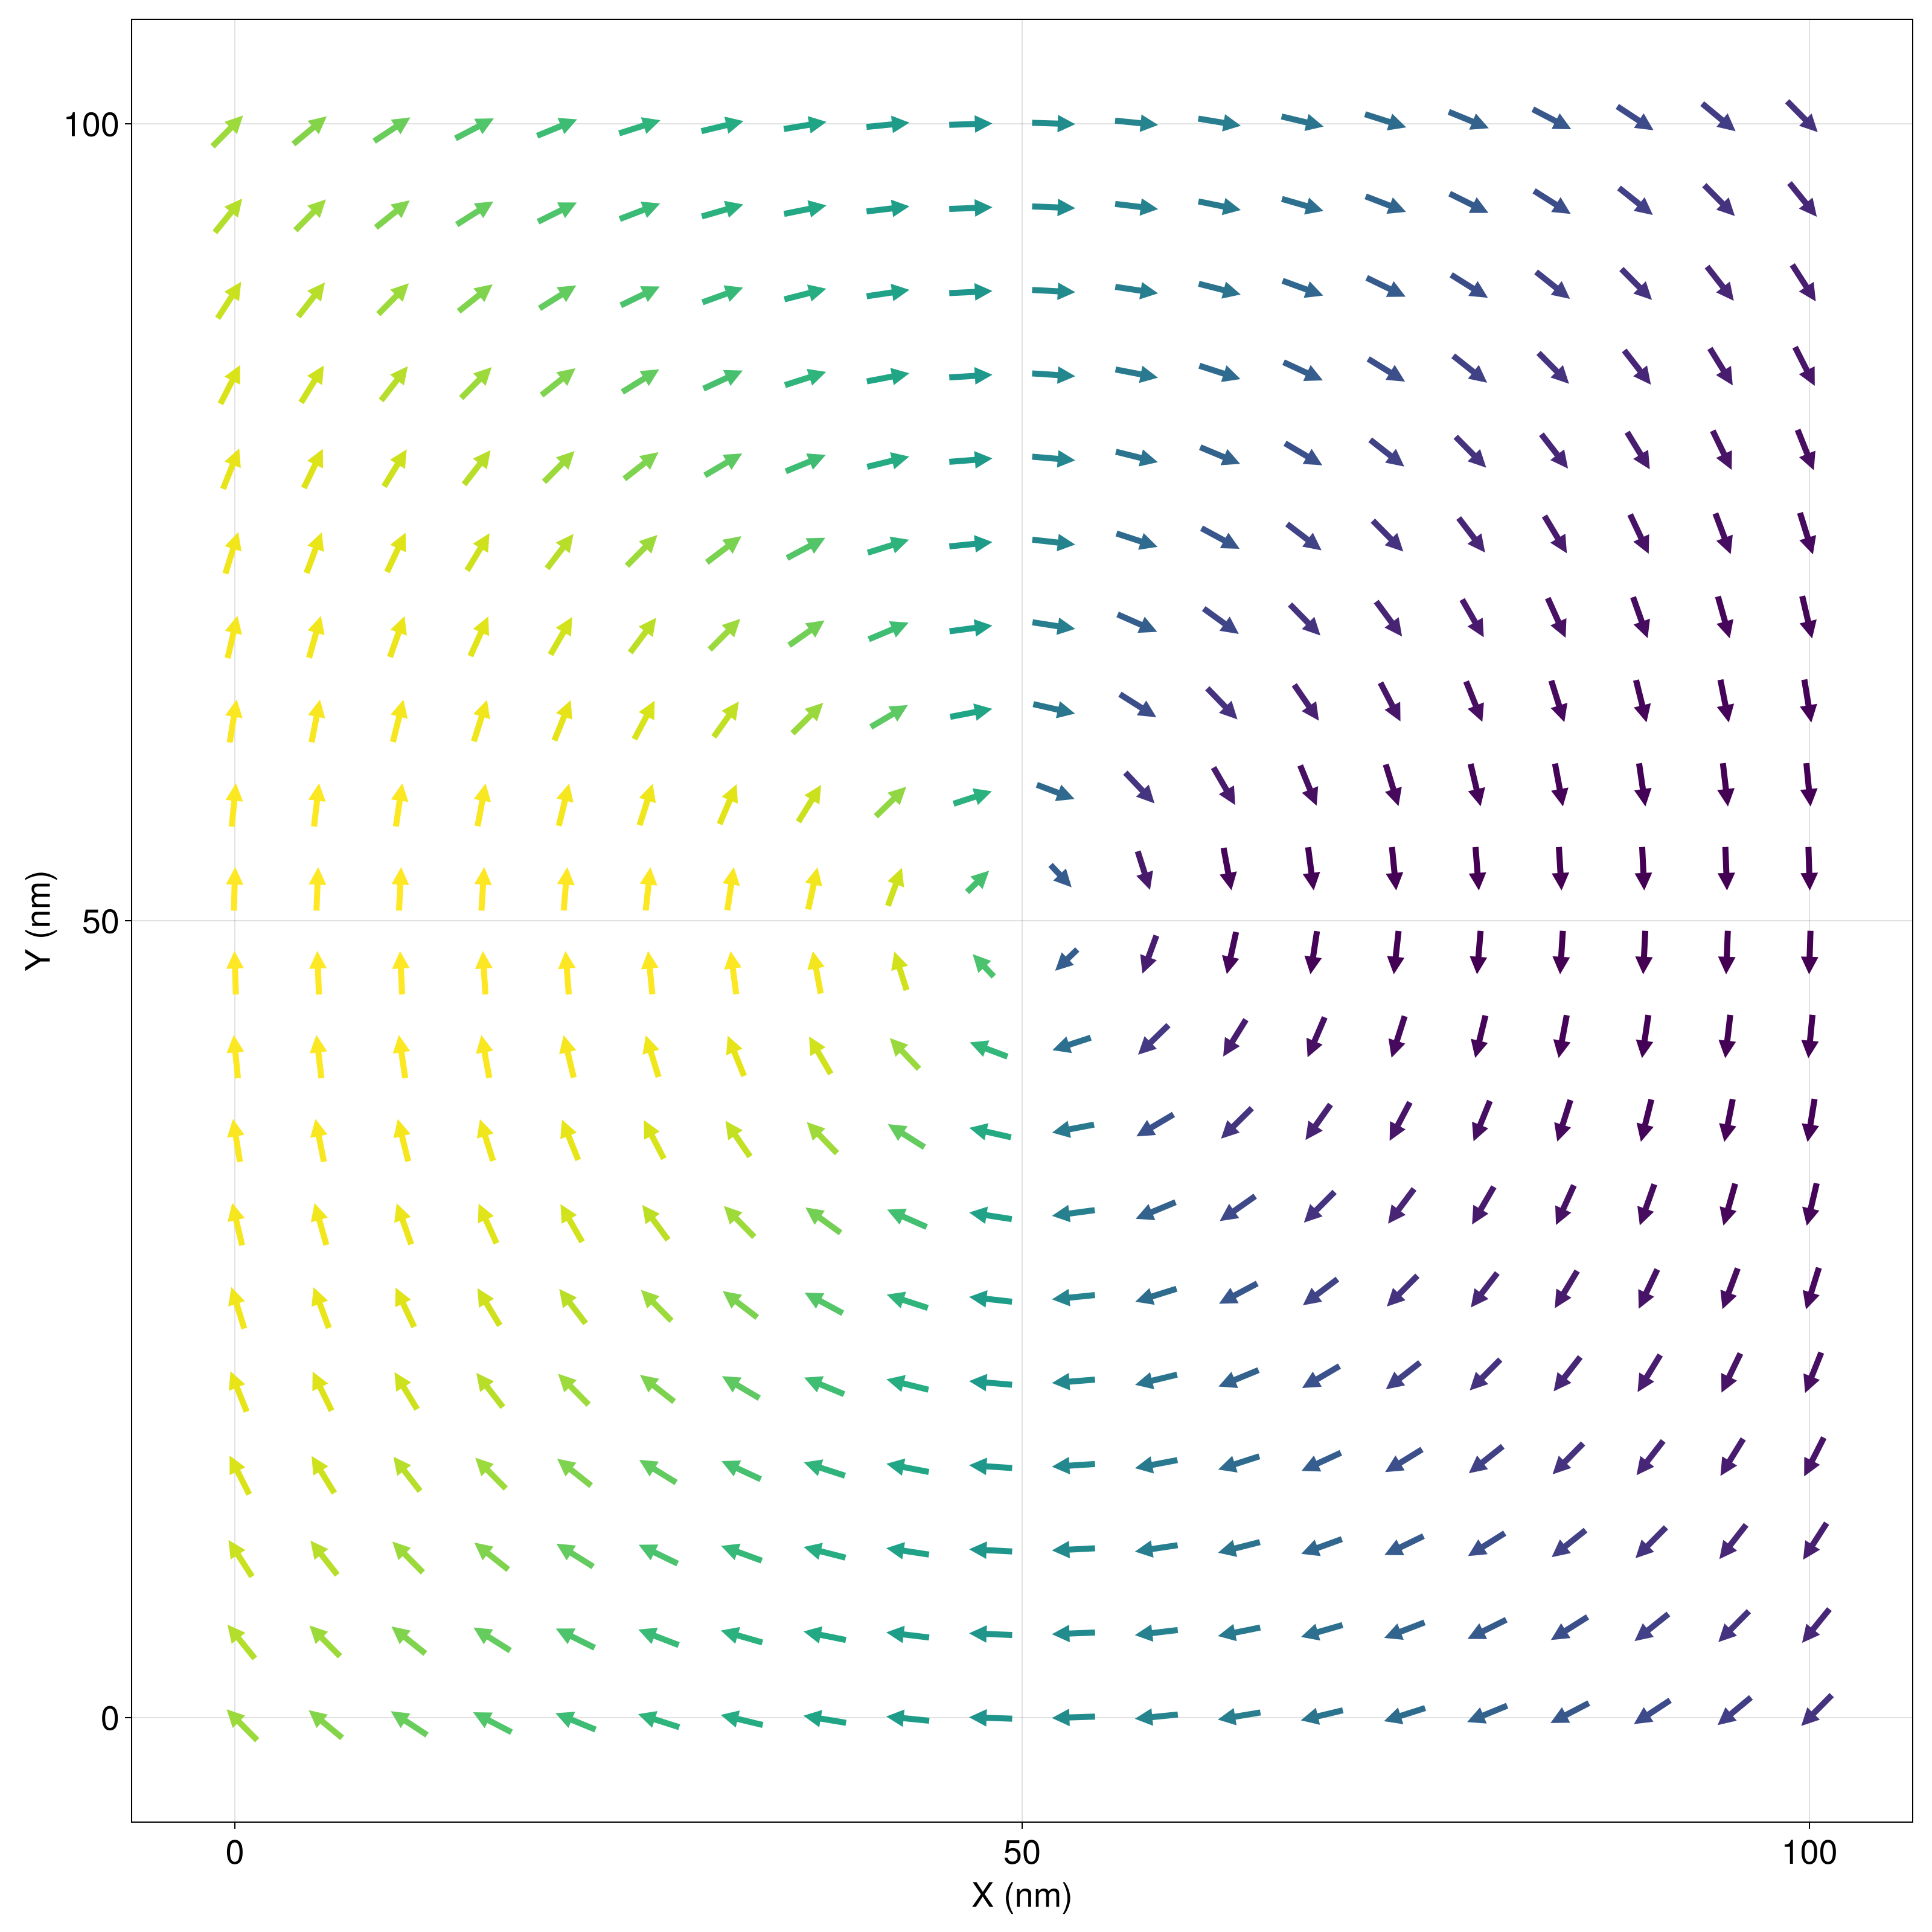

In [8]:
using CairoMakie
function plot_spatial_m()
    m = npzread("std5_m0.npy")
    nx, ny, nz = 20, 20, 2
    m = reshape(m, 3, nx, ny, nz)

    fig = Figure(size = (1600, 1600), fontsize=28)
    ax = Axis(fig[1, 1],
        xlabel = "X (nm)",
        ylabel = "Y (nm)"
        )
    xs = range(0, stop=100, length=nx)
    ys = range(0, stop=100, length=ny)
    mx = m[1, :, :, 1]
    my = m[2, :, :, 1]
    arrows!(ax, xs, ys, mx, my,
        lengthscale = 2, linewidth = 5, arrowsize = 20,
        arrowcolor = vec(my), linecolor =  vec(my), align = :center)

    save("assets/std5_static.png", fig, px_per_unit = 1) #src
    return fig
end

plot_spatial_m()

Now plot the track of vortex centre and the three components.

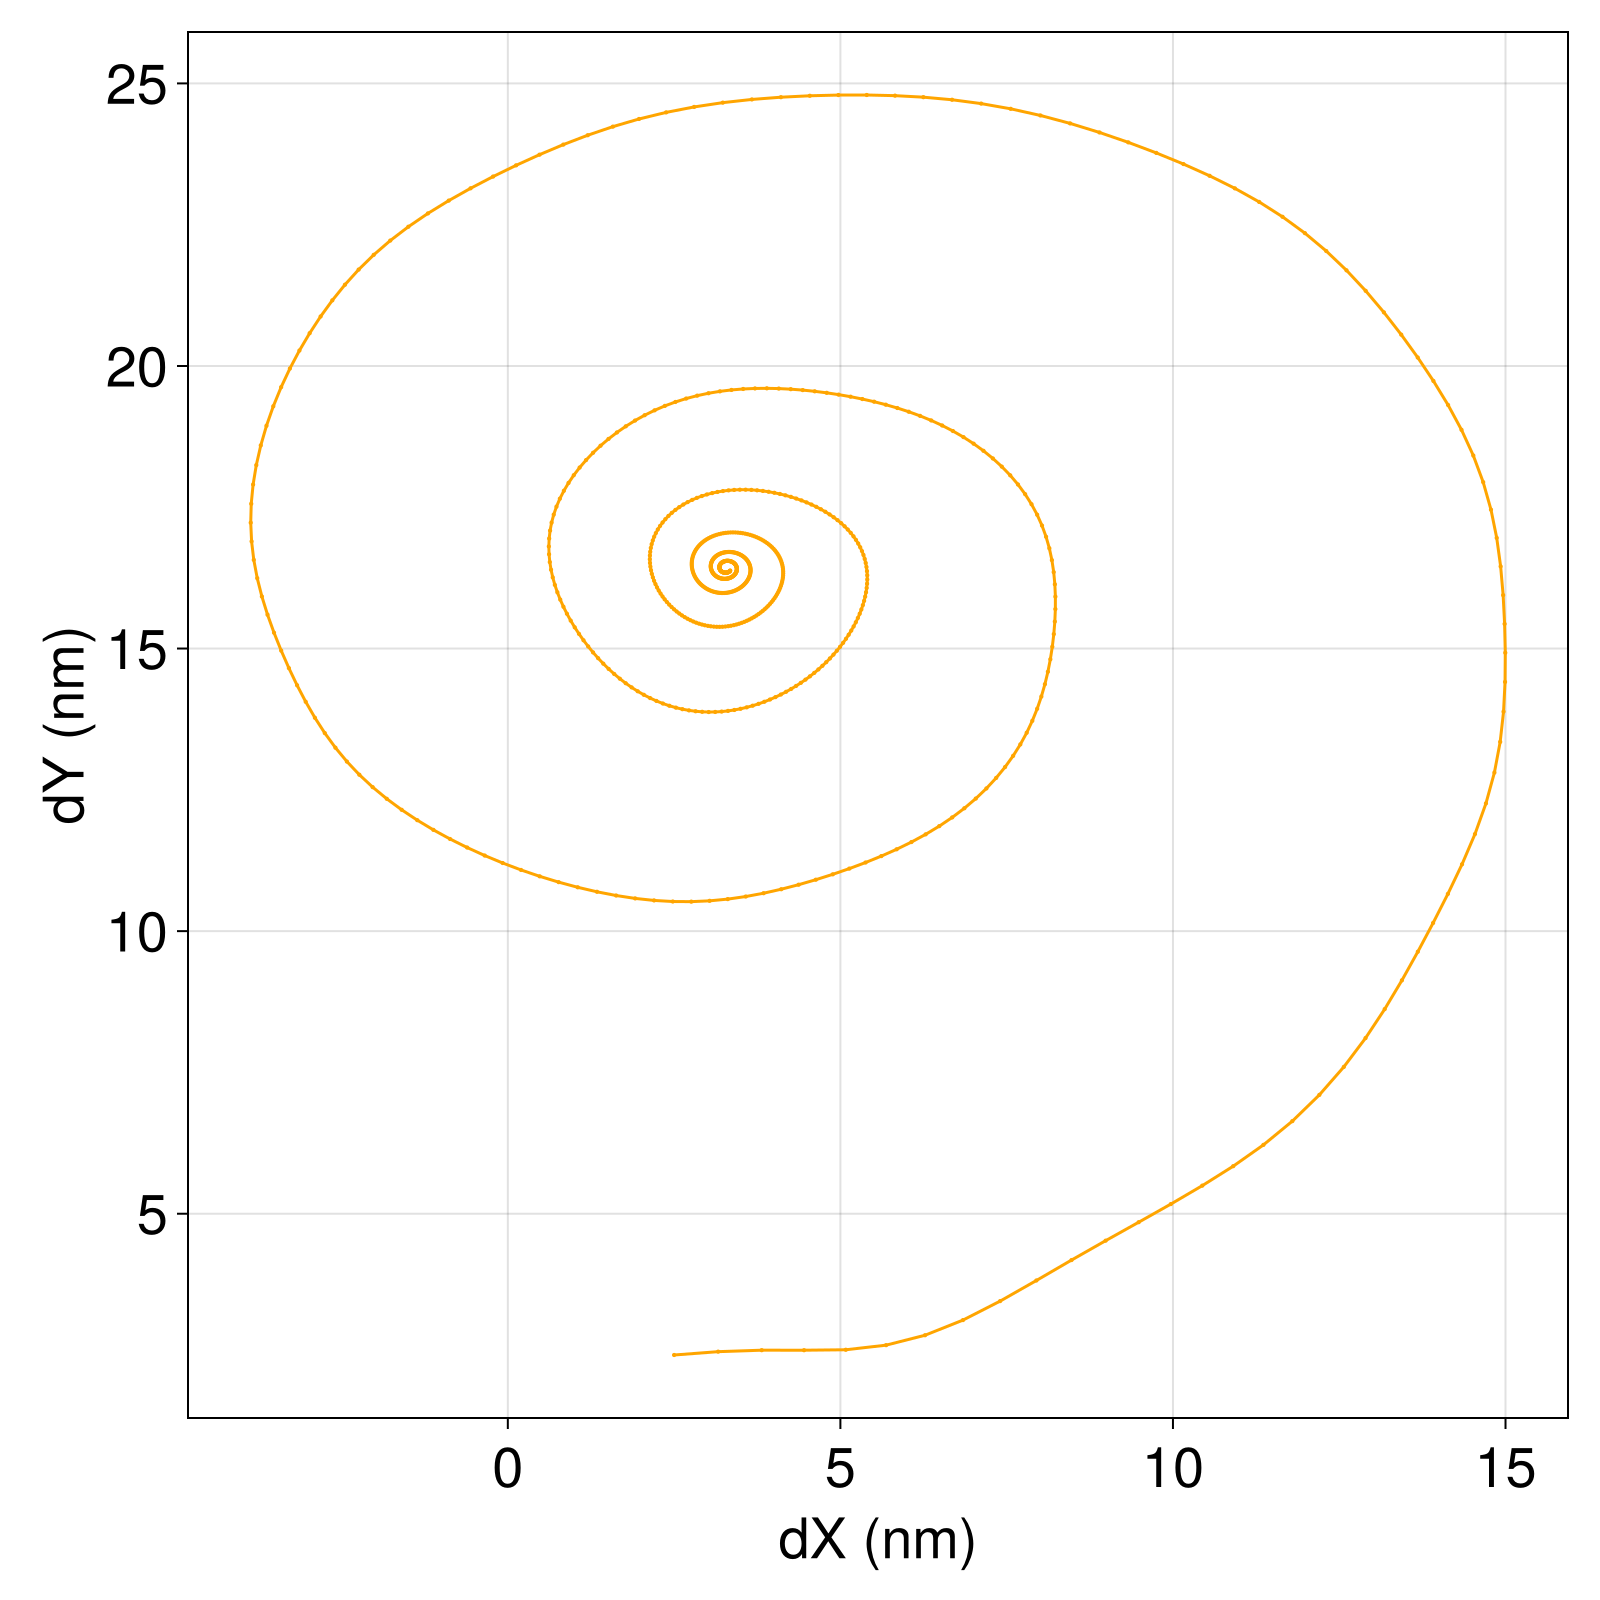

In [9]:
using DelimitedFiles

function plot_center()
    data_center = readdlm("std5_center.txt", skipstart=1)
    fig = Figure(size = (800, 800), fontsize=28)
    ax = Axis(fig[1, 1],
        xlabel = "dX (nm)",
        ylabel = "dY (nm)"
    )
    scatterlines!(ax, data_center[:,2]*1e9 .- 50, data_center[:,3]*1e9 .- 50,
        markersize = 3, color = :orange, markercolor = :orange)
    return fig
end

plot_center()

Finally, we plot the average magnetization as a function of time.

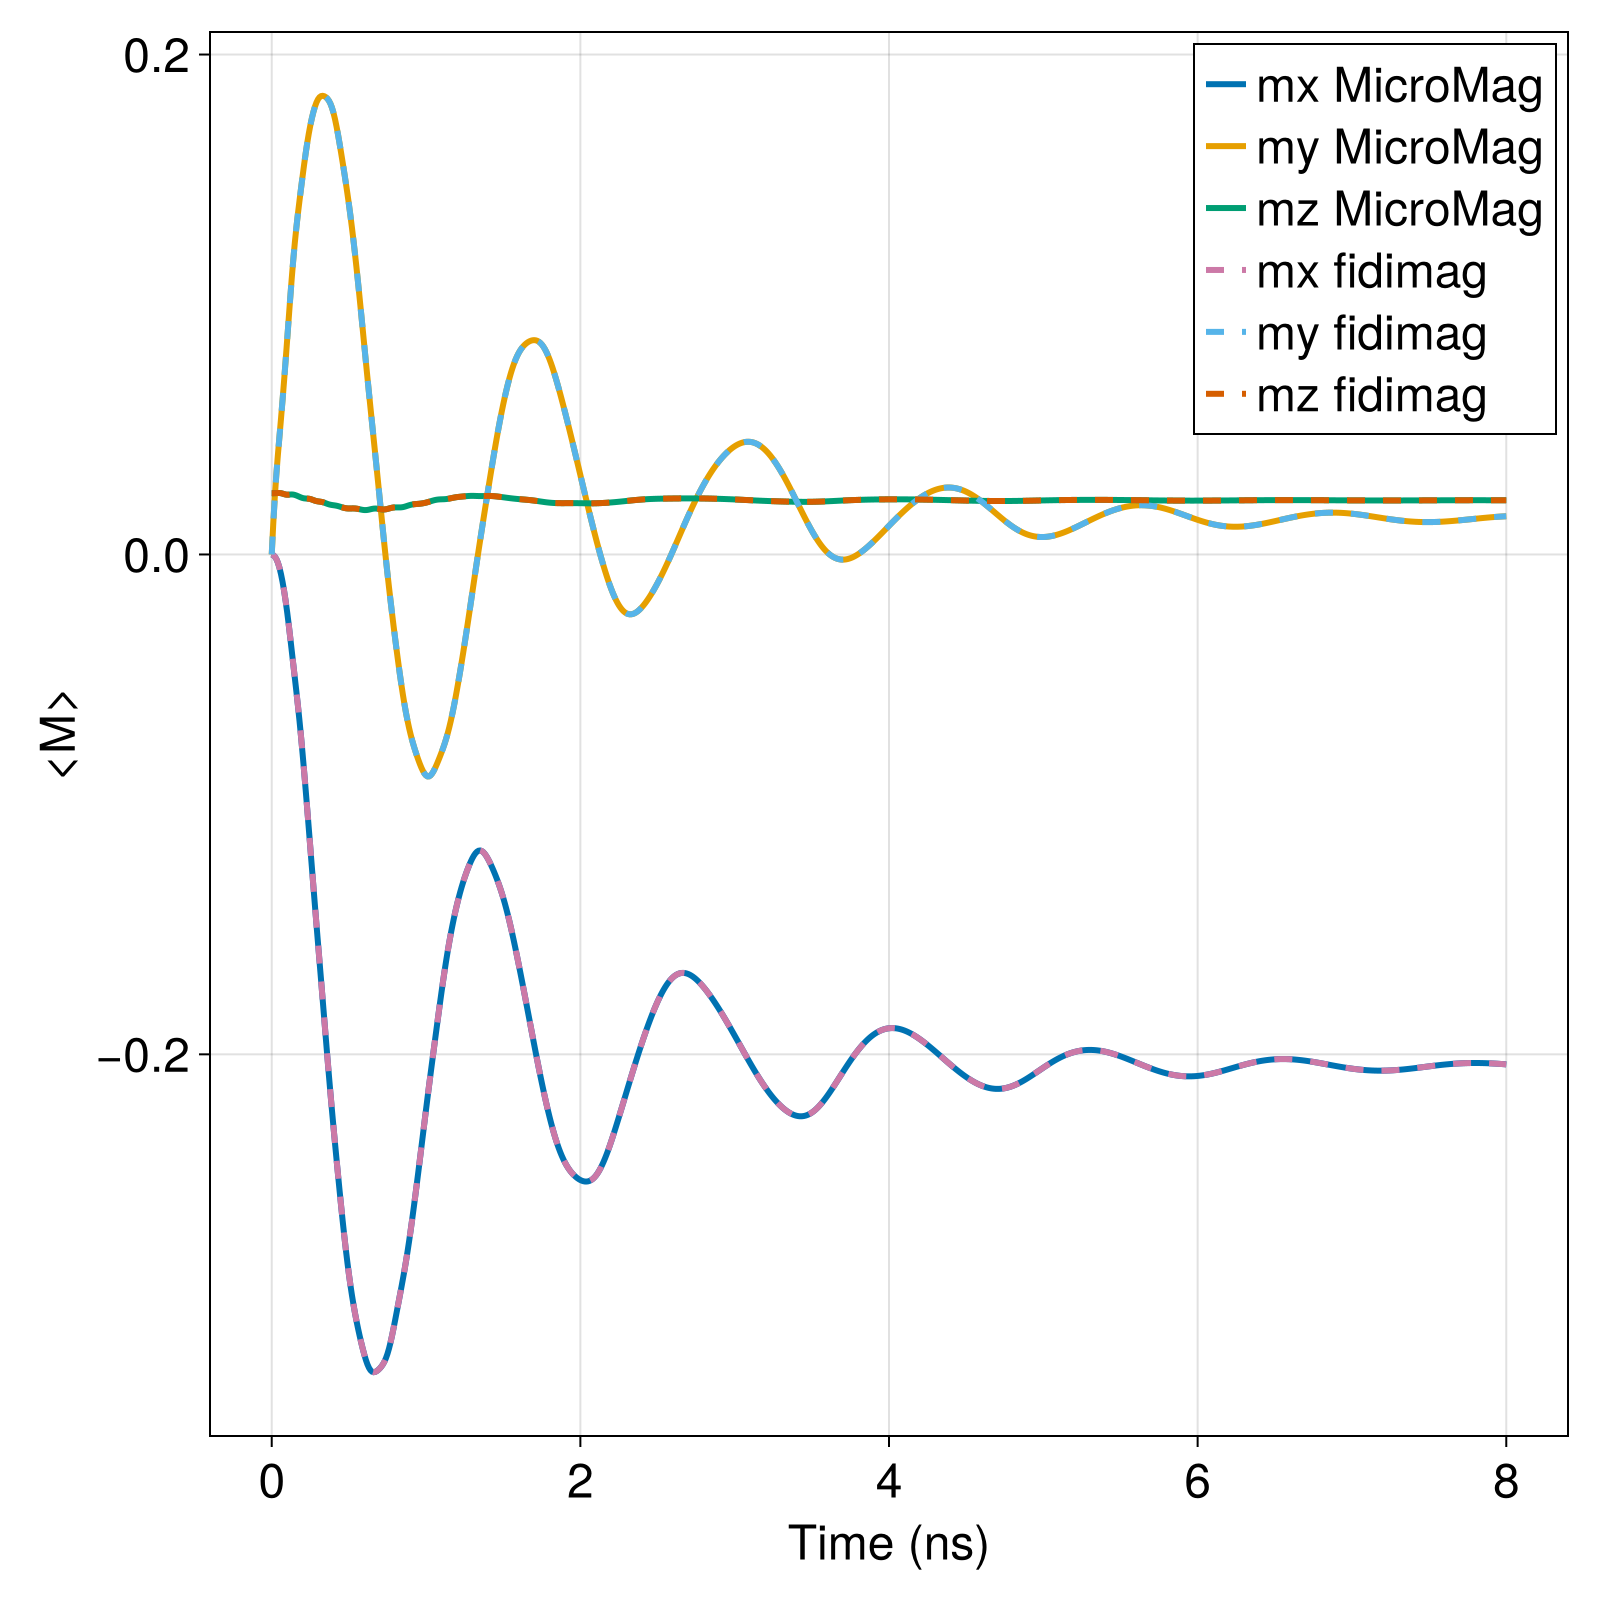

In [10]:
function plot_m()
    data = readdlm("std5_dyn_llg_stt.txt", skipstart=2)
    ts, mx, my, mz = data[:,2]*1e9, data[:,4],data[:,5],data[:,6]
    fig = Figure(size = (800, 800), fontsize=24)
    ax = Axis(fig[1, 1],
        xlabel = "Time (ns)",
        ylabel = "<M>"
    )
    lines!(ax, ts, mx, linewidth=3,label="mx MicroMag")
    lines!(ax, ts, my, linewidth=3,label="my MicroMag")
    lines!(ax, ts, mz, linewidth=3,label="mz MicroMag")

    data_fidimag = readdlm("assets/std5_fidimag_data.txt", skipstart=2)
    ts, mx, my, mz = data_fidimag[:,1]*1e9, data_fidimag[:,5], data_fidimag[:,6], data_fidimag[:,7]
    lines!(ax, ts, mx, linewidth=3, linestyle=:dash, label="mx fidimag")
    lines!(ax, ts, my, linewidth=3, linestyle=:dash, label="my fidimag")
    lines!(ax, ts, mz, linewidth=3, linestyle=:dash, label="mz fidimag")

    axislegend()
    return fig
end

plot_m()

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*